In [1]:
# Let's read the content of the uploaded Zernike coefficients file
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares


In [2]:
def zernike_to_defoucs(rmax, zernike_coefficients):
    """Convert Zernike coefficients to defocus and astigmatism."""
    defocus_from_zernike = 4*np.sqrt(3)/rmax**2 * zernike_coefficients[5] 
    # nimo设备有特定的修正系数
    defocus=defocus_from_zernike / (-0.248) -0.002 
    return defocus

def zernike_radial(m, n, r):
    """Calculate the radial part of Zernike polynomial."""
    z_radial = np.zeros_like(r)
    for s in range((n - abs(m)) // 2 + 1):
        c = (-1)**s * np.prod(np.arange(1, n - s + 1))
        c /= np.prod(np.arange(1, s + 1)) * np.prod(np.arange(1, (n + abs(m)) // 2 - s + 1)) * np.prod(np.arange(1, (n - abs(m)) // 2 - s + 1))
        z_radial += c * r**(n - 2 * s)
    return z_radial

def zernike_value(r, theta, zernike_coefficients):
    """Calculate the wavefront aberration at point (r, theta) using Zernike coefficients."""
    wavefront = 0
    for _, row in zernike_coefficients.iterrows():
        n, m = [int(x) for x in row['Z index'].strip('Z()').split(':')]
        if m >= 0:
            wavefront += row['value'] * zernike_radial(m, n, r) * np.cos(m * theta)
        else:
            wavefront += row['value'] * zernike_radial(-m, n, r) * np.sin(-m * theta)
    return wavefront


def zernike_fit_func(coefficients, r, theta, num_terms=6):
    """Compute wavefront aberration using a set of Zernike coefficients."""
    wavefront = np.zeros_like(r)
    # 这里只考虑前几项Zernike多项式
    for i in range(num_terms):
        n, m = i // 2, (2 * (i % 2) - 1) * (i // 2)
        if m >= 0:
            wavefront += coefficients[i] * zernike_radial(m, n, r) * np.cos(m * theta)
        else:
            wavefront += coefficients[i] * zernike_radial(-m, n, r) * np.sin(-m * theta)
    return wavefront

def residuals(coefficients, r, theta, w_actual):
    """Compute the residuals between actual and modeled wavefront aberrations."""
    return zernike_fit_func(coefficients, r, theta,num_terms=len(coefficients)) - w_actual

def wavefront_data(new_diameter,N_r,N_theta,zernike_data):
    r_max=new_diameter/2
    r_values = np.linspace(0, r_max, N_r)
    theta_values = np.linspace(0, 2 * np.pi, N_theta)
    r_grid, theta_grid = np.meshgrid(r_values, theta_values)
    r_coords = r_grid.flatten()
    theta_coords = theta_grid.flatten()
    w_values= zernike_value(r_coords, theta_coords, zernike_data)
    return r_coords,theta_coords,w_values

def recalculate_power(
        zernike_data,
        new_diameter,
        N_r=50,N_theta=100,
        fit_zernike_terms_N=50):
    r_coords,theta_coords,w_values=wavefront_data(new_diameter,N_r,N_theta,zernike_data)

    # 初始系数估计（这里我们简单地假设它们全都是0）
    initial_coefficients = np.ones(fit_zernike_terms_N)*0+1e-6

    # 进行最小二乘拟合
    result = least_squares(residuals, initial_coefficients, args=(r_coords, theta_coords, w_values))

    # 输出拟合得到的系数
    fitted_coefficients = result.x
    new_defocus=zernike_to_defoucs(new_diameter/2, fitted_coefficients)
    print(fitted_coefficients[5])
    return new_defocus


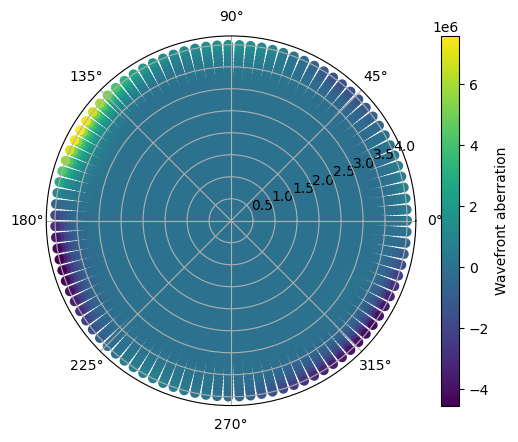

In [3]:
# filename='0.7-2nd cycle_zernike.csv'
filename='zernike_data\\8MM.csv'
zernike_data = pd.read_csv(filename)
r_coords,theta_coords,w_values=wavefront_data(8,50,100,zernike_data)
# 绘制极坐标图
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
c = ax.scatter(theta_coords, r_coords, c=w_values, cmap='viridis')
fig.colorbar(c, ax=ax, label='Wavefront aberration')
plt.show()

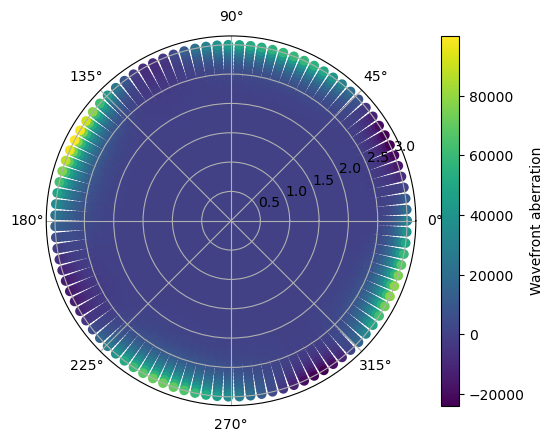

In [4]:
# filename='0.7-2nd cycle_zernike.csv'
filename='zernike_data\\6MM.csv'
zernike_data = pd.read_csv(filename)
r_coords,theta_coords,w_values=wavefront_data(6,50,100,zernike_data)
# 绘制极坐标图
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
c = ax.scatter(theta_coords, r_coords, c=w_values, cmap='viridis')
fig.colorbar(c, ax=ax, label='Wavefront aberration')
plt.show()

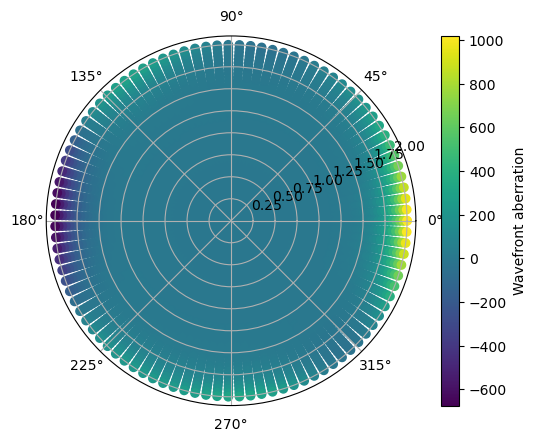

In [5]:
# filename='0.7-2nd cycle_zernike.csv'
filename='zernike_data\\4MM.csv'
zernike_data = pd.read_csv(filename)
r_coords,theta_coords,w_values=wavefront_data(4,50,100,zernike_data)
# 绘制极坐标图
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
c = ax.scatter(theta_coords, r_coords, c=w_values, cmap='viridis')
fig.colorbar(c, ax=ax, label='Wavefront aberration')
plt.show()